In [30]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('raw_meta_Beauty_and_Personal_Care_video_content_urls.csv')

# Filter rows where 'content_url' ends with '.mp4'
filtered_df = df[df['content_url'].str.endswith('.mp4', na=False)]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('./mp4_data/raw_meta_Automotive_video_content_urls.csv', index=False)


In [17]:
print(len(filtered_df))

692392


In [1]:
import av
import torch
import numpy as np

from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/home/grads/gjiaying/miniconda3/envs/peft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
import pandas as pd
import torch
import av

# Load data
data = pd.read_csv('./mp4_data/raw_meta_Beauty_and_Personal_Care_video_content_urls.csv')
print(len(data))
videos = data['content_url'].tolist()
titles = data['parent_title'].tolist()

# Store scores
xclip_scores = []

for i in range(len(titles)):  # or use `range(len(data))` for full dataset
    try:
        container = av.open(videos[i])
        indices = sample_frame_indices(clip_len=8, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
        video = read_video_pyav(container, indices)

        inputs = processor(
            text=[titles[i]],
            videos=list(video),
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        logits_per_video = outputs.logits_per_video
        score = logits_per_video.item()  # assuming 1 video-text pair, so scalar
        xclip_scores.append(score)

    except Exception as e:
        print(f"Error processing index {i}: {e}")
        xclip_scores.append(None)

# Add new column and save
data['x-clip_score'] = xclip_scores
data.to_csv('./mp4_data/beauty1_with_xclip_scores.csv', index=False)


41935


/home/grads/gjiaying/miniconda3/envs/peft/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `VideoMAEImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)
moov atom not found


Error processing index 263: [Errno 1094995529] Invalid data found when processing input: 'https://m.media-amazon.com/images/S/vse-vms-transcoding-artifact-us-east-1-prod/v2/c9579f27-30c5-503b-931a-f5a0dab58580/ShortForm-Generic-480p-16-9-1409173089793-rpcbe5.mp4'; last error log: [mov,mp4,m4a,3gp,3g2,mj2] moov atom not found


Stream ends prematurely at 17915089, should be 26099809
Invalid NAL unit size (5433 > 2106).
missing picture in access unit with size 2110
Invalid NAL unit size (5433 > 2106).
Error splitting the input into NAL units.


Error processing index 1064: [Errno 1094995529] Invalid data found when processing input: 'avcodec_send_packet()'; last error log: [h264] Error splitting the input into NAL units.
Error processing index 12239: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
Error processing index 12764: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
Error processing index 12765: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
Error processing index 28786: [Errno 875574520] Server returned 404 Not Found: 'https://m.media-amazon.com/images/S/vse-vms-transcoding-artifact-us-east-1-prod/v2/84865751-d5d8-552a-8433-44949ffa40ac/ShortForm-Generic-480p-16-9-1409173089793-rpcbe5.mp4'


Stream ends prematurely at 30392307, should be 99591578
stream 0, offset 0x1cfc0fd: partial file


Error processing index 41105: [Errno 5] Input/output error: 'https://m.media-amazon.com/images/S/vse-vms-transcoding-artifact-us-east-1-prod/v2/3fb75458-46c6-553d-81b4-8fcca03c9f47/ShortForm-Generic-480p-16-9-1409173089793-rpcbe5.mp4'; last error log: [mov,mp4,m4a,3gp,3g2,mj2] stream 0, offset 0x1cfc0fd: partial file


In [5]:
import pandas as pd

# Load the datasets
xclip_df = pd.read_csv('./mp4_data/beauty1_with_xclip_scores.csv')
videoclip_df = pd.read_csv('./mp4_data/beauty1_with_videoclip_scores.csv')
viclip_df = pd.read_csv('./mp4_data/beauty1_with_viclip_scores.csv')

# Extract the last column from each additional dataframe
xclip_df['videoclip_score'] = videoclip_df.iloc[:, -1]
xclip_df['viclip_score'] = viclip_df.iloc[:, -1]

# Save the combined dataframe to a new CSV
xclip_df.to_csv('./mp4_data/beauty1_all_clips.csv', index=False)

print("Combined CSV saved as 'beauty1_with_all_clip_scores.csv'")

Combined CSV saved as 'beauty1_with_all_clip_scores.csv'


In [6]:
import pandas as pd
import json
from collections import Counter

# Load your CSV file
df = pd.read_csv('./mp4_data/beauty1_all_clips.csv')

# Initialize counter for key frequency
details_key_counter = Counter()

for i, details_str in enumerate(df.get('details', [])):
    # Skip if NaN or empty
    if pd.isna(details_str) or not isinstance(details_str, str) or not details_str.strip():
        continue

    # Attempt to fix malformed JSON strings
    try:
        # First try parsing as-is
        details = json.loads(details_str)
    except json.JSONDecodeError:
        try:
            # Try replacing single quotes with double quotes
            safe_str = details_str.replace("'", '"')
            details = json.loads(safe_str)
        except json.JSONDecodeError:
            continue  # Skip if still malformed

    # Update counter if it's a dict
    if isinstance(details, dict):
        details_key_counter.update(details.keys())

# Sort and display results
sorted_attributes = details_key_counter.most_common()
for attr, count in sorted_attributes:
    print(f"{attr}: {count}")


Brand: 37261
Item Form: 23005
Color: 16810
Hair Type: 11533
Scent: 10922
Skin Type: 10675
Material: 10198
Country of Origin: 5700
Finish Type: 4719
Shape: 2439
Power Source: 2284
Mounting Type: 989
Skin Tone: 832
Pattern: 460
Theme: 373
Language: 339
Package Type: 324
Installation Type: 310
Frame Type: 301
Head Type: 248
Fabric Type: 238
Embellishment: 183
Flavor: 160
Towel form type: 157
Blade Edge: 153
Operation Mode: 95
Occasion: 92
Closure Type: 73
Target Audience: 70
Cartoon Character: 58
Seasons: 56


In [ ]:
import pandas as pd
import numpy as np

# === Load CSV file ===
df = pd.read_csv('./mp4_data/automotive_all_clips.csv')  # Replace with your actual filename

# === Extract the last three columns (assumed order: xclip, videoclip, viclip) ===
xclip_col = df.columns[-3]
videoclip_col = df.columns[-2]
viclip_col = df.columns[-1]

# === Calculate 20th percentile thresholds ===
xclip_thresh = np.percentile(df[xclip_col], 20)
videoclip_thresh = np.percentile(df[videoclip_col], 20)
viclip_thresh = np.percentile(df[viclip_col], 20)

# === Count how many scores exceed their thresholds per row ===
above_thresholds = (
    (df[xclip_col] > xclip_thresh).astype(int) +
    (df[videoclip_col] > videoclip_thresh).astype(int) +
    (df[viclip_col] > viclip_thresh).astype(int)
)

# === Filter rows where at least two scores exceed thresholds ===
filtered_df = df[above_thresholds >= 2]

# === Save to new CSV ===
filtered_df.to_csv('./final_data/sports.csv', index=False)

print(f"Filtered dataset saved with {len(filtered_df)} samples.")


Filtered dataset saved with 34537 samples.


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load your CSV file that contains the three score columns (assumed to be the last 3 columns)
df = pd.read_csv('./mp4_data/beauty1_all_clips.csv')

# Extract last three columns as score matrix
score_cols = df.columns[-3:]
score_data = df[score_cols]

# Compute z-scores for each column
z_scores = score_data.apply(zscore)

# Apply filtering: Keep rows where at least 2 z-scores are above a threshold (e.g., -1.0)
threshold = -1.0
mask = (z_scores > threshold).sum(axis=1) >= 2
filtered_df = df[mask]

# Save filtered result
filtered_df.to_csv('./final_data/beauty1.csv', index=False)

print(f"Filtered dataset size: {len(filtered_df)} (out of {len(df)})")


Filtered dataset size: 36211 (out of 43625)


In [15]:
import pandas as pd
import ast

# Load the dataset
df = pd.read_csv('./final_data/beauty1.csv')

# Function to clean and filter the 'details' column
def filter_details(details):
    try:
        # Convert the string to a dictionary (this assumes it's a string representation of a dictionary)
        details_dict = ast.literal_eval(details)
    except:
        # In case there's any parsing error, return the original details
        return details

    # Filter out attributes where value contains a comma or more than 3 words
    filtered_details = {k: v for k, v in details_dict.items() if len(v.split()) <= 3 and ',' not in v}

    # If only one attribute-value pair remains, remove this record
    if len(filtered_details) == 1:
        return None  # Return None to indicate we should drop this record

    # Return the filtered details as a string
    return str(filtered_details)

# Apply the filter function to the 'details' column
df['aspects'] = df['details'].apply(filter_details)

# Remove rows where filtered details are None (i.e., only one attribute-value pair)
df = df[df['aspects'].notna()]

# Optionally, remove the old 'details' column if you don't need it anymore
df.drop('details', axis=1, inplace=True)
df.drop(['x-clip_score', 'videoclip_score', 'viclip_score'], axis=1, inplace=True)
# Save the cleaned dataset
df.to_csv('./final_data/beauty1_v1.csv', index=False)

# Show the cleaned dataframe for inspection
print(df.head())


   product_id                                          video_url  \
0  B07FXWHFRF  https://www.amazon.com/vdp/37eb0d67eba64b258d3...   
1  B002YK53YC  https://www.amazon.com/vdp/492e34b5371443a6bb0...   
2  B09HJHXVZW  https://www.amazon.com/vdp/7771e9aade8249939ea...   
3  B09HJHXVZW  https://www.amazon.com/vdp/0f7282af4ab841f182d...   
4  B0C23Y3RK6  https://www.amazon.com/vdp/7daf5f02723c4105917...   

                                         content_url  \
0  https://m.media-amazon.com/images/S/vse-vms-tr...   
1  https://m.media-amazon.com/images/S/vse-vms-tr...   
2  https://m.media-amazon.com/images/S/vse-vms-tr...   
3  https://m.media-amazon.com/images/S/vse-vms-tr...   
4  https://m.media-amazon.com/images/S/vse-vms-tr...   

                                         video_title  \
0  Asara New York is at the Forefront of Probioti...   
1          Style Code Live: Rose Gold Beauty | Nails   
2            Code Blue - D/Code Antiperspirant Stick   
3  Dead Down Wind Field Spray 

In [16]:
import pandas as pd
import json
from collections import defaultdict, Counter

# Load the CSV
df = pd.read_csv('./final_data/beauty1_v1.csv')  # Replace with your actual CSV filename

# Initialize a dictionary of Counters to count frequency of values per attribute
attribute_counter = defaultdict(Counter)

# Iterate through each row in the 'details' column
for detail_str in df['aspects']:
    try:
        # Safely parse the string into a dictionary
        detail_dict = json.loads(detail_str.replace("'", '"'))  # Fix single quotes to double quotes
        for key, value in detail_dict.items():
            # Count the value occurrence for each attribute
            attribute_counter[key.strip()][value.strip()] += 1
    except Exception as e:
        continue  # Skip rows with parsing errors

# Now, for each attribute, rank the values by frequency in descending order
for attribute, value_counter in attribute_counter.items():
    print(f"Attribute: {attribute}")
    sorted_values = value_counter.most_common()  # Sort by frequency in descending order
    for value, count in sorted_values:
        print(f"  {value} — {count}")
    print()  # Add a blank line between different attributes for readability


Attribute: Brand
  Maybelline New York — 420
  Raya — 346
  L’Oréal Paris — 323
  Ardell — 286
  Dove — 270
  COVERGIRL — 209
  PHILIPS — 184
  WAHL — 174
  Beauty Junkees — 171
  Remington — 163
  Secret — 160
  Conair — 149
  ZOYA — 136
  Braun — 136
  Garnier — 128
  Wet Brush — 125
  NYX PROFESSIONAL MAKEUP — 119
  OPI — 116
  Vaseline — 110
  REVLON — 109
  SheaMoisture — 108
  Olay — 108
  Old Spice — 108
  Pulleez — 102
  jane iredale — 102
  GOODY — 102
  MAYBELLINE — 100
  Neutrogena — 94
  Jane iredale — 88
  Babor — 88
  MAKARI — 86
  LORAC — 85
  Suave — 84
  Panasonic — 83
  Enjoy — 83
  Pantene — 81
  Gillette — 78
  PHYTO — 77
  Simple — 76
  AXE — 76
  AIMEILI — 76
  SHANY — 71
  John Frieda — 70
  Aveeno — 69
  HASK — 69
  Elizavecca — 69
  DEGREE — 68
  Vichy — 67
  Real Techniques — 66
  Born Pretty — 66
  Docolor — 65
  Andis — 65
  DearKlairs — 64
  Head & Shoulders — 64
  JAPONESQUE — 63
  Badger — 61
  Julep — 61
  Lime Crime — 60
  Swiss Arabian — 59
  MIZON — 5

num_attributes
0       920
2      8740
3     13163
4      8625
5      2727
6       556
7       173
8        99
9        25
10        2
Name: count, dtype: int64


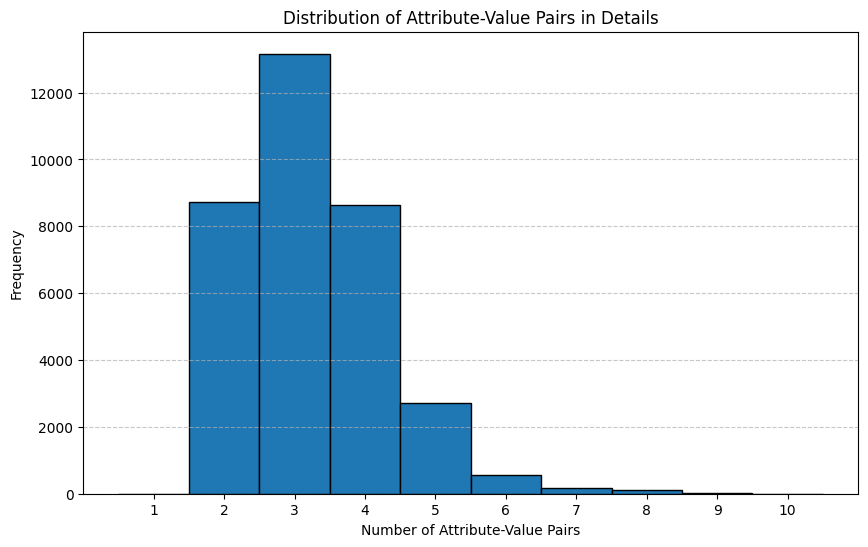

In [17]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the cleaned CSV file
df = pd.read_csv('./final_data/beauty1_v1.csv')  # Replace with your actual cleaned dataset filename

# Function to count the number of attribute-value pairs in the 'details' column
def count_attributes(details_str):
    try:
        # Convert the 'details' column string back to a dictionary
        details_dict = json.loads(details_str.replace("'", '"'))  # Ensure the format is valid JSON
        
        # Return the number of attribute-value pairs
        return len(details_dict)
    except Exception as e:
        # In case of error, return 0 (skip the problematic row)
        return 0

# Apply the count function to the 'details' column
df['num_attributes'] = df['aspects'].apply(count_attributes)

# Calculate the distribution of the number of attribute-value pairs
distribution = df['num_attributes'].value_counts().sort_index()

# Print the distribution
print(distribution)

# Optional: Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['num_attributes'], bins=range(1, df['num_attributes'].max() + 2), edgecolor='black', align='left')
plt.title('Distribution of Attribute-Value Pairs in Details')
plt.xlabel('Number of Attribute-Value Pairs')
plt.ylabel('Frequency')
plt.xticks(range(1, df['num_attributes'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
import pandas as pd

# Load your dataset
df = pd.read_csv('./final_data/beauty1_v1.csv')  # Replace with your actual cleaned dataset filename

# Randomly select 10% of the data
sampled_df = df.sample(frac=0.1, random_state=42)  # random_state ensures reproducibility

# Save the sampled data as a separate CSV (optional)
sampled_df.to_csv('./final_data/beauty_test.csv', index=False)

# Get the remaining 90% of the data by dropping the sampled data from the original DataFrame
remaining_df = df.drop(sampled_df.index)

# Save the remaining data (training data) to a new CSV
remaining_df.to_csv('./final_data/beauty_train.csv', index=False)

# Optionally, print the number of training samples
print(f"Training data saved with {len(remaining_df)} samples.")
print(len(sampled_df))


Training data saved with 31527 samples.
3503


In [12]:
import requests
import os

def download_mp4(url, save_path):
    """
    Download an MP4 video from a URL and save it to the given local path.
    
    Args:
        url (str): The URL of the .mp4 video.
        save_path (str): Local file path where the video should be saved (including .mp4).
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                f.write(chunk)
        #print(f"Downloaded to {save_path}")
    else:
        print(f"Failed to download video. Status code: {response.status_code}")


192
